# Imputacja braków danch metodą k najbliższych sąsiadów - kNN
### Projekt w ramach przedmiotu Teoria i projektowanie badań reprezentacyjnych

## Import potrzebnych bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Wczytanie danych

In [2]:
df = pd.read_csv("fake_bills.csv", sep = ";")
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


## Szukanie braków danych

In [3]:
print(
    df['is_genuine'].isnull().sum(),
    df['diagonal'].isnull().sum(),
    df['height_left'].isnull().sum(),
    df['height_right'].isnull().sum(),
    df['margin_low'].isnull().sum(),
    df['margin_up'].isnull().sum(),
    df['length'].isnull().sum()
)

0 0 0 0 37 0 0


<AxesSubplot: >

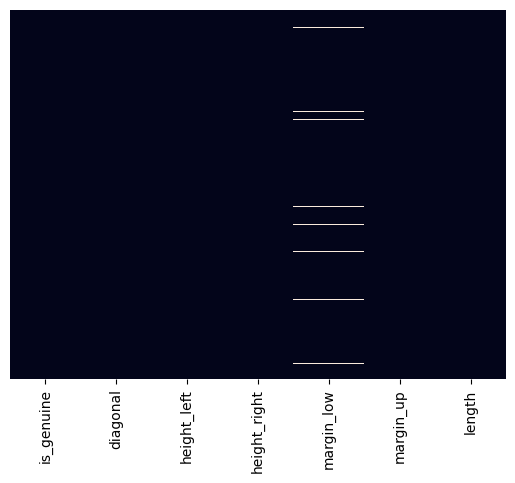

In [4]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)

## Standaryzacja skali

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop('is_genuine', axis=1))
scaled_features = scaler.transform(df.drop('is_genuine', axis=1))    # wyrzucamy zmienną objaśnianą modelu końcowego, logiczną

In [6]:
df_feat = pd.DataFrame(scaled_features, columns = df.columns[1:]) 
df_feat.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.051286,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.078937,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.129549,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.304982,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.672057,1.417677,-0.158750


## Imputacja - sposób "na piechotę"

### - wyodrębnienie wierszy z brakami i bez

In [7]:
nan = df_feat[df_feat['margin_low'].isnull()]
nan.head(5)

,diagonal,height_left,height_right,margin_low,margin_up,length
72,-0.060441,-0.466103,-1.444792,NaN,0.425168,0.127803
99,-0.093217,0.135176,0.797784,NaN,-0.049510,0.460204
151,0.365659,-0.766742,1.412188,NaN,-0.567341,0.288272
197,-1.666506,-1.234404,-0.369585,NaN,2.021814,0.677984
241,-0.420986,0.369007,0.429141,NaN,-0.567341,-0.365069


In [8]:
nanX = nan.drop('margin_low', axis=1)

In [9]:
df_feat = df_feat.dropna()
df_feat

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.051286,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.078937,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.129549,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.304982,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.672057,1.417677,-0.158750
...,...,...,...,...,...,...
1495,-0.683201,1.170713,0.767063,-0.099410,-0.265273,-1.602978
1496,0.758981,2.005822,1.596509,1.181509,0.942999,-1.958303
1497,-0.519316,-0.065250,0.613462,1.543181,0.899846,-0.835016
1498,0.332882,0.836669,0.429141,1.030813,1.331372,-0.491152


### - zdefiniowanie zmiennych modelu

In [10]:
X1 = df_feat.drop('margin_low', axis=1).values
y1 = df_feat['margin_low'].values

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, 
                                                        test_size = 0.2, 
                                                        random_state = 1)

In [13]:
pd.DataFrame(X1_test).isnull().sum().sum()

0

In [14]:
X1_train.shape

(1170, 5)

In [15]:
y1_test.shape

(293,)

In [16]:
y1_train.shape

(1170,)

### - inicjalizacja modelu (regresja przy pomocy kNN)

In [17]:
from sklearn.neighbors import KNeighborsRegressor

In [18]:
knnR = KNeighborsRegressor(n_neighbors=3)

In [19]:
knnR.fit(X1_train, y1_train)

KNeighborsRegressor(n_neighbors=3)

In [20]:
preds1 = knnR.predict(X1_test)

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [22]:
mse1 = mean_squared_error(y1_test, preds1)
rmse1 = sqrt(mse1)
rmse1

0.7881971490884696

### - dostosowanie hiperparametrów

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
parameters = {
    "n_neighbors": range(1,50),
    "weights": ["uniform", "distance"]
}

gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X1_train, y1_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [25]:
gridsearch.best_params_

{'n_neighbors': 36, 'weights': 'uniform'}

In [26]:
train_preds_grid = gridsearch.predict(X1_train)
train_mse = mean_squared_error(y1_train, train_preds_grid)
train_rmse = sqrt(train_mse)

test_preds_grid = gridsearch.predict(X1_test)
test_mse = mean_squared_error(y1_test, test_preds_grid)
test_rmse = sqrt(test_mse)

print(train_rmse, test_rmse)

0.6679266797667162 0.6562769239826853


In [27]:
print(df_feat['margin_low'].min(), df_feat['margin_low'].max())

-2.2694388212177827 3.637861307289517


### Porównanie prognozy do wartości faktycznych

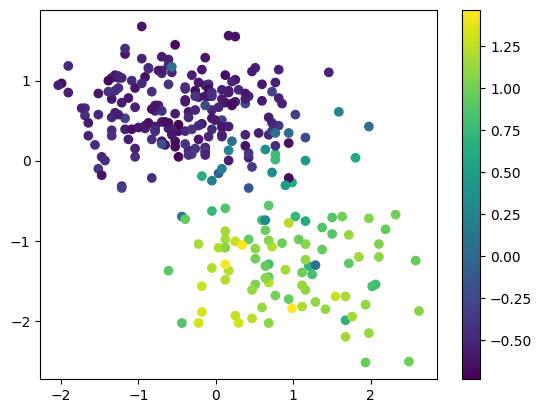

In [28]:
f, ax =plt.subplots()
points = ax.scatter(X1_test[:, 3], X1_test[:, 4], c=test_preds_grid)  #4, 
f.colorbar(points)
plt.show()

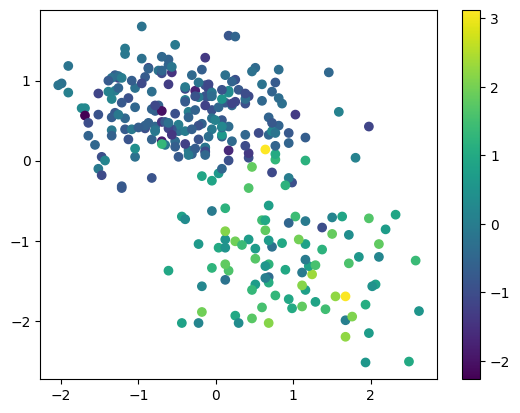

In [29]:
f, ax =plt.subplots()
points = ax.scatter(X1_test[:, 3], X1_test[:, 4], c=y1_test)  #4, 
f.colorbar(points)
plt.show()

### - predykcja braków danych

In [30]:
nan_pred = gridsearch.predict(nanX)
nan_pred

C:\Users\asiaz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


array([-0.58415039, -0.31205961, -0.51047658, -0.43429116,  0.22668013,
       -0.59252242, -0.54312747, -0.53768566, -0.64108015, -0.67121944,
       -0.52429042, -0.54898789, -0.53810426, -0.49959295, -0.52722063,
       -0.61261527, -0.4489422 , -0.40833789, -0.52429042, -0.60884786,
       -0.49666274, -0.29364116, -0.53559265, -0.40289607, -0.56238313,
       -0.53433685, -0.65405679,  0.75328044, -0.586662  ,  1.06681274,
        0.69132746,  1.40462391,  1.03918506,  0.96718565,  1.11369607,
        0.71769934,  1.1584864 ])

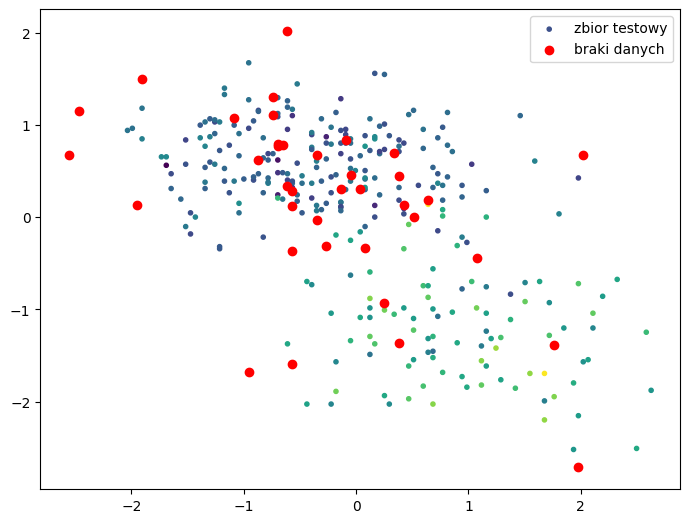

In [31]:
fig = plt.Figure()
ax = fig.add_axes((0,0,1,1))
plot1 = ax.scatter(x=X1_test[:, 3], y=X1_test[:, 4], c=y1_test, marker='.')
plot2 = ax.scatter(x=nanX.iloc[:, 3], y=nanX.iloc[:, 4], c='red', marker='o')
ax.legend([plot1, plot2], ['zbior testowy', 'braki danych'])
fig

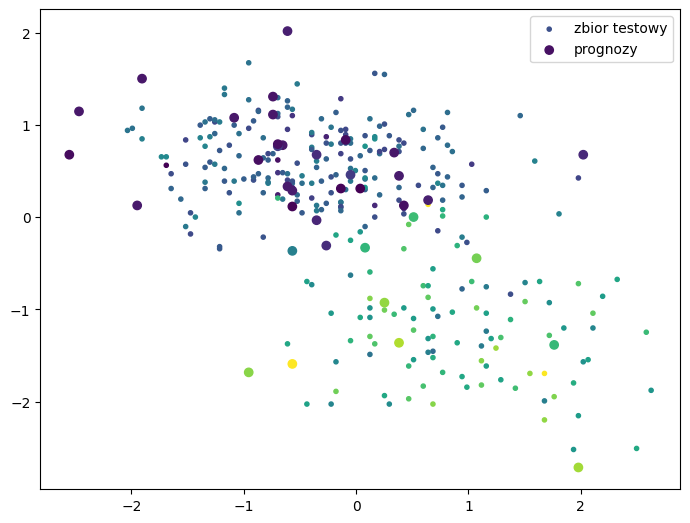

In [32]:
fig = plt.Figure()
ax = fig.add_axes((0,0,1,1))
plot1 = ax.scatter(x=X1_test[:, 3], y=X1_test[:, 4], c=y1_test, marker='.')
plot2 = ax.scatter(x=nanX.iloc[:, 3], y=nanX.iloc[:, 4], c=nan_pred, marker='o')
ax.legend([plot1, plot2], ['zbior testowy', 'prognozy'])
fig

### - łączenie ramek danych
#### Na koniec uzyskujemy początkową ramkę df z uzupełnionymi brakami danych

In [33]:
nanX = nanX.reset_index(drop=True)
nanX = pd.DataFrame(nanX)
nan_pred = pd.DataFrame(nan_pred)
df2 = pd.concat([nanX, nan_pred], axis=1)
df2.rename(columns = {df2.columns[5]: 'margin_low'}, inplace=True)
df2.head()

,diagonal,height_left,height_right,margin_up,length,margin_low
0,-0.060441,-0.466103,-1.444792,0.425168,0.127803,-0.584150
1,-0.093217,0.135176,0.797784,-0.049510,0.460204,-0.312060
2,0.365659,-0.766742,1.412188,-0.567341,0.288272,-0.510477
3,-1.666506,-1.234404,-0.369585,2.021814,0.677984,-0.434291
4,-0.420986,0.369007,0.429141,-0.567341,-0.365069,0.226680


#### cały zbiór bez zmiennej is_genuine:

In [34]:
df3 = pd.concat([df2, df_feat])
# df3.isnull().sum().sum()
df3

,diagonal,height_left,height_right,margin_up,length,margin_low
0,-0.060441,-0.466103,-1.444792,0.425168,0.127803,-0.584150
1,-0.093217,0.135176,0.797784,-0.049510,0.460204,-0.312060
2,0.365659,-0.766742,1.412188,-0.567341,0.288272,-0.510477
3,-1.666506,-1.234404,-0.369585,2.021814,0.677984,-0.434291
4,-0.420986,0.369007,0.429141,-0.567341,-0.365069,0.226680
...,...,...,...,...,...,...
1495,-0.683201,1.170713,0.767063,-0.265273,-1.602978,-0.099410
1496,0.758981,2.005822,1.596509,0.942999,-1.958303,1.181509
1497,-0.519316,-0.065250,0.613462,0.899846,-0.835016,1.543181
1498,0.332882,0.836669,0.429141,1.331372,-0.491152,1.030813


#### cały zbiór razem ze zmienną is_genuine, bez braków danych:

In [35]:
target = df['is_genuine']
target = pd.DataFrame(target)

In [36]:
target = target.reset_index(drop=True)
df3 = df3.reset_index(drop=True)

In [37]:
df = pd.concat([target, df3], axis=1)
df.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
0,True,-0.060441,-0.466103,-1.444792,0.425168,0.127803,-0.584150
1,True,-0.093217,0.135176,0.797784,-0.049510,0.460204,-0.312060
2,True,0.365659,-0.766742,1.412188,-0.567341,0.288272,-0.510477
3,True,-1.666506,-1.234404,-0.369585,2.021814,0.677984,-0.434291
4,True,-0.420986,0.369007,0.429141,-0.567341,-0.365069,0.226680


In [38]:
df['margin_low'].isnull().sum()

0

## Imputacja - sposób z pakietem scikit-learn
#### Domyślnie używa metryki euklidesowej

In [39]:
from sklearn.impute import KNNImputer

In [40]:
df['margin_low'].isnull().sum()

0

In [41]:
imputer = KNNImputer(n_neighbors=36, weights="uniform")
df = imputer.fit_transform(df)
df = pd.DataFrame(df, columns = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'])

In [42]:
df['margin_low'].isnull().sum()

0

## Model kNN - klasyfikacja

### Zdefiniowanie i podział zmiennych

In [43]:
X = df.drop("is_genuine", axis = 1)
X = X.values
y = df["is_genuine"]
y = y.values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 12345)

### Inicjalizacja modelu - klasyfikator

In [45]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
knn_model = KNeighborsClassifier(n_neighbors=3)

In [47]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [48]:
test_preds = knn_model.predict(X_test)
train_preds = knn_model.predict(X_train)

In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [50]:
print(accuracy_score(y_train, train_preds))
print(accuracy_score(y_test, test_preds))

0.9816666666666667
0.98


In [51]:
print(confusion_matrix(y_test,test_preds))
print(classification_report(y_test,test_preds))

[[ 83   4]
 [  2 211]]
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97        87
         1.0       0.98      0.99      0.99       213

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



### Dostosowanie parametrów

In [52]:
parameters = {
    "n_neighbors": range(1,50),
    "weights": ["uniform", "distance"]
}

gridsearch2 = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch2.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [53]:
gridsearch2.best_params_

{'n_neighbors': 16, 'weights': 'uniform'}

In [54]:
knn_model2 = KNeighborsClassifier(n_neighbors=6, weights='distance')

In [55]:
knn_model2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6, weights='distance')

In [56]:
test_preds2 = knn_model.predict(X_test)
train_preds2 = knn_model.predict(X_train)

In [57]:
accuracy_score(y_test, test_preds2)

0.98

In [58]:
print(confusion_matrix(y_test,test_preds2))
print(classification_report(y_test,test_preds2))

[[ 83   4]
 [  2 211]]
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97        87
         1.0       0.98      0.99      0.99       213

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



### Porównanie prognozy do wartości faktycznych

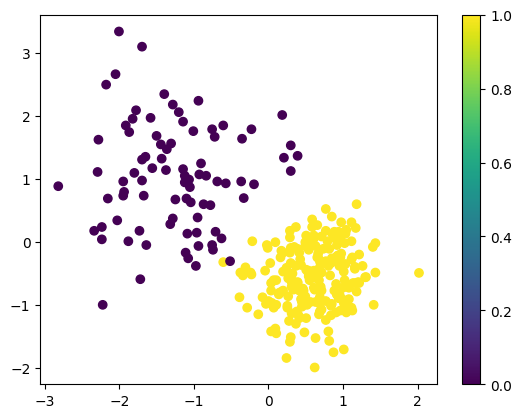

In [59]:
f, ax =plt.subplots()
points = ax.scatter(X_test[:, 4], X_test[:, 5], c=test_preds)     # 0+3, 0+5, 1+3, 1+5, 2+3, 2+5, 3+4, 3+5, 4+5
f.colorbar(points)
plt.show()

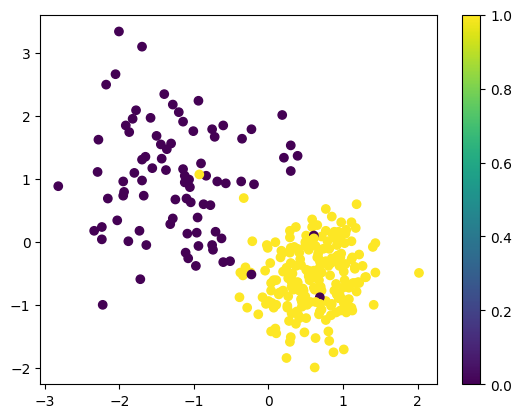

In [60]:
f, ax =plt.subplots()
points = ax.scatter(X_test[:, 4], X_test[:, 5], c=y_test)
f.colorbar(points)
plt.show()